# Import module


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import properscoring as ps

from save_tools import *

# Reading of file Netcdf

In [2]:
def lec_compute_rmse(infile):
    """
    
    Netcdf file reading function and calculation of CRPS and RMSE
    Inputs:
    -infile: file to read
    Outputs:
    -Date: date list (object)
    -Q_obs: Q observed (function of time)
    -Q_ens: Q simulated (function of time, for each member)
    -S_ens: S simulated (function of time, for each member)

    """
       
    print('lecture ', infile)
    data_0 = lec_tabs(infile)

    Q_obs      = data_0['Q_obs']
    S_obs      = data_0['S_obs']
    Q_ens      = data_0['Q_ens']
    S_ens      = data_0['S_ens']

    npdt, n_ens = np.shape(Q_ens)

    Q_vrai      = data_0['Q_vrai']
    S_vrai      = data_0['S_vrai']

    S_n_ens     = np.zeros((npdt, 10, n_ens)) 

    S_n_ens[:, 0, :]      = data_0['S_1_ens']
    S_n_ens[:, 1, :]      = data_0['S_2_ens']
    S_n_ens[:, 2, :]      = data_0['S_3_ens']
    S_n_ens[:, 3, :]      = data_0['S_4_ens']
    S_n_ens[:, 4, :]      = data_0['S_5_ens']
    S_n_ens[:, 5, :]      = data_0['S_6_ens']
    S_n_ens[:, 6, :]      = data_0['S_7_ens']
    S_n_ens[:, 7, :]      = data_0['S_8_ens']
    S_n_ens[:, 8, :]      = data_0['S_9_ens']
    S_n_ens[:, 9, :]     = data_0['S_10_ens']

    fneige_ens   = data_0['fneige_ens']
    PS_ens       = data_0['PS_ens']
    T_ens        = data_0['T_ens']
    PS           = data_0['PS']
    TS           = data_0['TS']
    RMSE_PS_ens  = data_0['RMSE_PS_ens']
    RMSE_TS_ens  = data_0['RMSE_TS_ens']
    RMSE_Q_ens   = data_0['RMSE_Q_ens']
    RMSE_S_ens   = data_0['RMSE_S_ens']
    YYYY       = data_0['DATE'][0, :]
    mm         = data_0['DATE'][1, :]
    dd         = data_0['DATE'][2, :]
    HH         = data_0['DATE'][3, :]
    MM         = data_0['DATE'][4, :]
    
    
    #date list
    date_l = list()
    for i_t in range(npdt):
        date_l.append(datetime.datetime(year=int(YYYY[i_t]), month=int(mm[i_t]), day=int(dd[i_t])))
    
    # quadratic differences for RMSE calculation of S_n
    diff_quad_S_n     = np.zeros((npdt, 10))
    for i_t in range(npdt):
        for i_level in range(10):
            diff_quad_S_n[i_t, i_level] = np.sum((S_n_ens[i_t, i_level, :] - S_obs[i_t])**2)

    
    return date_l, Q_obs, Q_ens, S_obs, S_n_ens, diff_quad_S_n

In [3]:
list_annees = [2016]

# number of years to plot
N_an = len(list_annees)

for i_an in range(N_an):
    
    annee = list_annees[i_an]
    
    # start date init (after spin-up)
    d_deb_known   = str(annee-3) + "-09-01"
    # end date ini
    d_end_known   = str(annee) + "-03-31"

    # start date to plot
    d_ini_plot = str(annee) + "-01-01"
    # d_ini_plot = str(annee) + "-03-01"

    # end date fin to plot
    d_fin_plot = str(annee) + "-03-31"


    # free set file without assimilation
    save_file_ensli = "Assimilation_sans_FP_"+str(annee)

    # assimilation file
    save_file_assim = "Assimilation_FP_Q_"+str(annee)

    # overall size for assimilation
    N_p = 50 #50

    # Nb  of truth
    N_verites   = 12




    ####################################
    ###########

    d_ikn = datetime.datetime.strptime(d_deb_known, '%Y-%m-%d')
    d_ekn = datetime.datetime.strptime(d_end_known, '%Y-%m-%d')

    d_plt = datetime.datetime.strptime(d_ini_plot, '%Y-%m-%d')
    d_fip = datetime.datetime.strptime(d_fin_plot, '%Y-%m-%d')

    # file reading



    for numero_ver in range(N_verites):
        # reading file set free without assimilation
        file_in_ensli = save_file_ensli+"_"+str(numero_ver)+".nc"
        date_l, Q_obs_ensli, Q_ens_ensli, S_obs_ensli, S_n_ensli, diff_quad_S_n_ensli = lec_compute_rmse(file_in_ensli)

        # rading assimilation file
        file_in_assim = save_file_assim+"_"+str(numero_ver)+".nc"
        date_l, Q_obs_assim, Q_ens_assim, S_obs_assim, S_n_assim, diff_quad_S_n_assim = lec_compute_rmse(file_in_assim)
        
        if numero_ver == 0:
            # start and end plot index search
            ind_deb = np.where(np.asarray(date_l)==d_plt)[0][0]
            ind_fin = np.where(np.asarray(date_l)==d_fip)[0][0]

            # If February 29th is in the dates then we take a day off at the end #
            # To have the same number of days in each year #
            list_date = date_l[ind_deb:ind_fin]
            d_28fev = datetime.datetime.strptime(str(annee) + '-02-28', '%Y-%m-%d')
            # search if February 28th is in the date list
            if d_28fev in list_date:
                # find out if the next day is the 29th, if yes then you have to take off one day
                if (d_28fev + datetime.timedelta(days = 1)).day == 29: ind_fin = ind_fin -1
            
            list_date = date_l[ind_deb:ind_fin]

            temp_RMSE_n_S_ensli = np.zeros((ind_fin - ind_deb, 10))
            temp_RMSE_n_S_assim = np.zeros((ind_fin - ind_deb, 10))
            
            # we create the output table (if it's the first year)
            if i_an==0:
                ratio_RMSE_n_S = np.zeros((ind_fin - ind_deb, 10, N_an))
            
            temp_RMSE_cumulQ_ensli = np.zeros(( N_verites))
            temp_RMSE_cumulQ_assim = np.zeros(( N_verites))

        # computation RMSE n_S on the period between start and end, and we sum the RMSE of all verities
        temp_RMSE_n_S_ensli[:, :] += np.sqrt( diff_quad_S_n_ensli[ind_deb:ind_fin, :] / (ind_fin - ind_deb) )
        temp_RMSE_n_S_assim[:, :] += np.sqrt( diff_quad_S_n_assim[ind_deb:ind_fin, :] / (ind_fin - ind_deb) )

        # RMSE calculation cumulation Q n_S on the period between start and finish
        temp_RMSE_cumulQ_ensli[ numero_ver] = np.sqrt( np.sum((np.sum(Q_ens_ensli[ind_deb:ind_fin, :], axis=0) \
                                              - np.sum(Q_obs_ensli[ind_deb:ind_fin]))**2 / (ind_fin - ind_deb)) / N_p )
        temp_RMSE_cumulQ_assim[ numero_ver] = np.sqrt( np.sum((np.sum(Q_ens_assim[ind_deb:ind_fin, :], axis=0) \
                                              - np.sum(Q_obs_assim[ind_deb:ind_fin]))**2 / (ind_fin - ind_deb)) / N_p )


    #cumulative RMSE ratio of Q
    ratio_RMSE_cumQ = temp_RMSE_cumulQ_assim / temp_RMSE_cumulQ_ensli


    # we divide by the number of truths, so we get the average RMSEs of snow
    temp_RMSE_n_S_ensli[:, :] /= N_verites
    temp_RMSE_n_S_assim[:, :] /= N_verites

    # snow RMSE ratio
    ratio_RMSE_n_S[:, :, i_an] = temp_RMSE_n_S_assim[:, :] / temp_RMSE_n_S_ensli[:, :]


Mean_ratio_RMSE_n_S = np.zeros((ind_fin - ind_deb, 10))
Mean_ratio_RMSE_n_S[:, :] = np.mean(ratio_RMSE_n_S, axis=2)

('lecture ', 'Assimilation_sans_FP_2016_0.nc')
('lecture ', 'Assimilation_FP_Q_2016_0.nc')
('lecture ', 'Assimilation_sans_FP_2016_1.nc')
('lecture ', 'Assimilation_FP_Q_2016_1.nc')
('lecture ', 'Assimilation_sans_FP_2016_2.nc')
('lecture ', 'Assimilation_FP_Q_2016_2.nc')
('lecture ', 'Assimilation_sans_FP_2016_3.nc')
('lecture ', 'Assimilation_FP_Q_2016_3.nc')
('lecture ', 'Assimilation_sans_FP_2016_4.nc')
('lecture ', 'Assimilation_FP_Q_2016_4.nc')
('lecture ', 'Assimilation_sans_FP_2016_5.nc')
('lecture ', 'Assimilation_FP_Q_2016_5.nc')
('lecture ', 'Assimilation_sans_FP_2016_6.nc')
('lecture ', 'Assimilation_FP_Q_2016_6.nc')
('lecture ', 'Assimilation_sans_FP_2016_7.nc')
('lecture ', 'Assimilation_FP_Q_2016_7.nc')
('lecture ', 'Assimilation_sans_FP_2016_8.nc')
('lecture ', 'Assimilation_FP_Q_2016_8.nc')
('lecture ', 'Assimilation_sans_FP_2016_9.nc')
('lecture ', 'Assimilation_FP_Q_2016_9.nc')
('lecture ', 'Assimilation_sans_FP_2016_10.nc')
('lecture ', 'Assimilation_FP_Q_2016_10.nc

# Plot

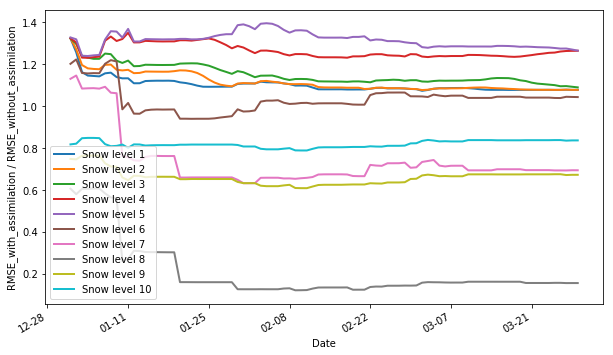

In [4]:


# plot key figure RMSE S for each level as a function of time

fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot(111)

for i_l in range(10):
    plt.plot(list_date[:], Mean_ratio_RMSE_n_S[:, i_l], label='Snow level '+str(i_l + 1), linewidth=2.0)

plt.xlabel("Date")
plt.ylabel('RMSE_with_assimilation / RMSE_without_assimilation')

# to have only the month and day in the dates #
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

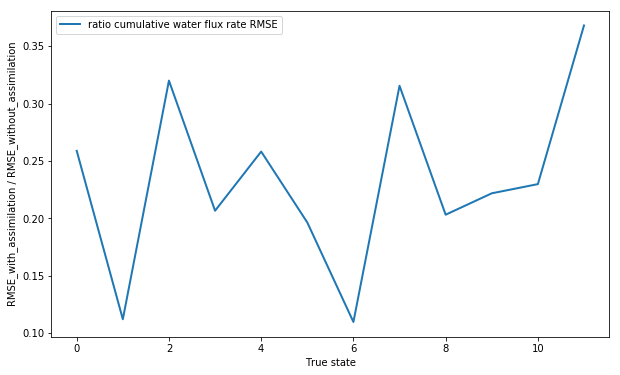

In [5]:

#plot ratio RMSE cumul de Q pour chaque verite

fig = plt.figure(1, figsize=(10, 6))
plt.plot(range(N_verites), ratio_RMSE_cumQ[:], label='ratio cumulative water flux rate RMSE', linewidth=2.0)
plt.xlabel("True state")
plt.ylabel('RMSE_with_assimilation / RMSE_without_assimilation')
plt.legend()
plt.show()

